# Time Analysis
* In this notebook, we look at the translation times DeepL and GPT4.1 had for the same tasks

In [2]:
from os.path import join
import pandas as pd
import json
import os

os.makedirs('time_results', exist_ok=True)

parts = ['ep-gpt', 'ep-deepl', 'flores-gpt', 'flores-deepl', 'opus-gpt', 'opus-deepl']

with open(join('translations', 'info.json'), 'r') as f:
    prefix2file = json.load(f)

for part in parts:
    data = {'Label':[], 'Time':[]}
    for prefix, info in prefix2file.items():
        if prefix.startswith(part):
            src_lang, tgt_lang = prefix.split('-')[2], prefix.split('-')[3]
            duration = info['log']['end'] - info['log']['start']
            data['Label'].append(f'{src_lang}-{tgt_lang}')
            data['Time'].append(duration)
    df = pd.DataFrame(data)
    df.to_csv(join('time_results', f'{part}.csv'))

In [3]:
from scripts.scoring import create_matrix_from_csv
import os
file2df = {f.replace('.csv', ''):{'file':join('time_results', f), 'df':None} for f in os.listdir('time_results')}

for f, content in file2df.items():
    file_path = content['file']
    df = create_matrix_from_csv(file_path, metric='Time')
    file2df[f]['TIME'] = df


## Statistics
* To compare this data more efficiently, it makes sense to employ techniques such as normalization

In [4]:
norm = {}
for f, content in file2df.items():
    df = content['TIME']
    normalized_df = (df - df.mean().mean()) / df.stack().std()
    norm[f] = normalized_df

ep-deepl


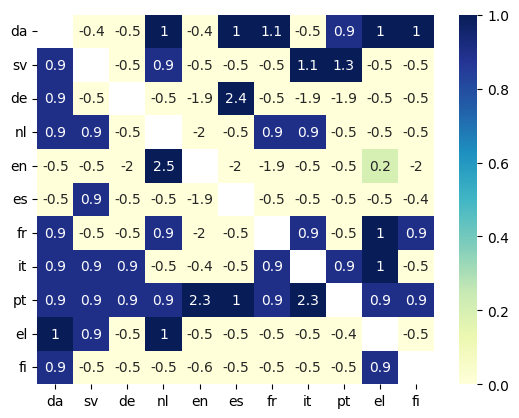


ep-gpt


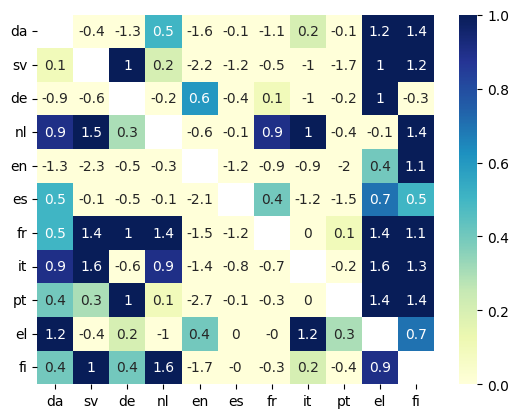


flores-deepl


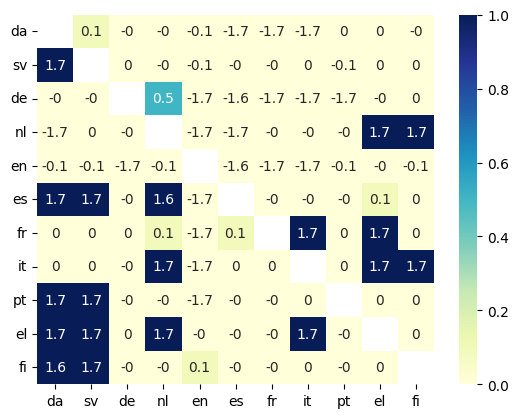


flores-gpt


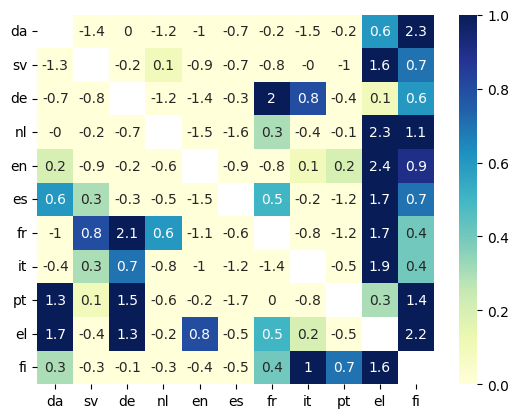


opus-deepl


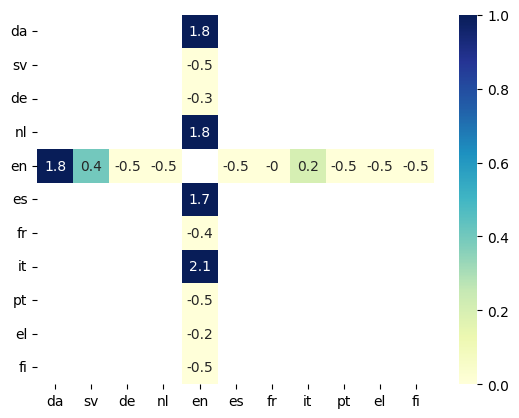


opus-gpt


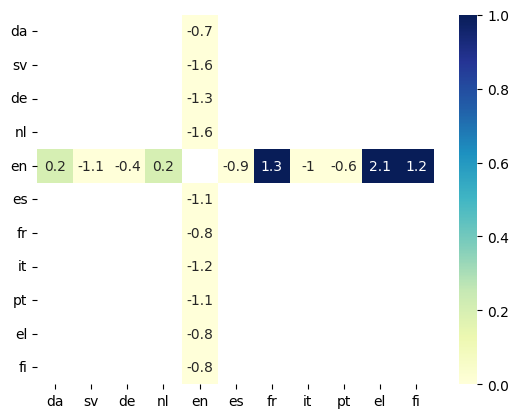

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
order = ['da', 'sv', 'de', 'nl', 'en', 'es', 'fr', 'it', 'pt', 'el', 'fi']
for key in norm:
    out = norm[key].round(1)
    out = out.reindex(index=order, columns=order)
    print(key)
    sns.heatmap(out, annot=True, cmap="YlGnBu", cbar=True, vmin=0, vmax=1)
    plt.yticks(rotation=0)
    plt.show()
    print()

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

parts = ['ep', 'flores', 'opus']

for part in parts:
    gpt = f'{part}-gpt'
    deepl = f'{part}-deepl'
    gpt_df = file2df[gpt]['TIME']
    deepl_df = file2df[deepl]['TIME']

    gpt_flat = gpt_df.values.flatten()
    deepl_flat = deepl_df.values.flatten()
    
    mask = ~np.isnan(gpt_flat) & ~np.isnan(deepl_flat)

    # Compute Pearson correlation
    corr, pval = pearsonr(gpt_flat[mask], deepl_flat[mask])
    print(f"Pearson correlation: {corr:.2f}")
    print(f"p-value: {pval:3f}")

Pearson correlation: 0.19
p-value: 0.048976
Pearson correlation: 0.28
p-value: 0.003265
Pearson correlation: -0.26
p-value: 0.268835
